# Basic Deep Q-learning
Disclaimer: this notebook is an adopted version of the seminar of [this repository](https://github.com/yandexdataschool/Practical_RL).

In this notebook you will teach a __pytorch__ neural network to do Q-learning.

In [63]:
# in google colab uncomment these lines:

# import os

# os.system('apt-get install -y xvfb')
# os.system('wget https://raw.githubusercontent.com/karfly/learning-deep-learning/master/10_q_learning/xvfb -O xvfb')
# os.system('apt-get install -y python-opengl ffmpeg')
# os.system('pip install pyglet==1.2.4')

# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash xvfb start
    %env DISPLAY = : 1

Today we'll use library `gym`. **Gym** is a toolkit for developing and comparing reinforcement learning algorithms. It supports teaching agents everything from walking to playing games like Pong or Pinball.

In [64]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Let's create `CartPole-v0` environment:

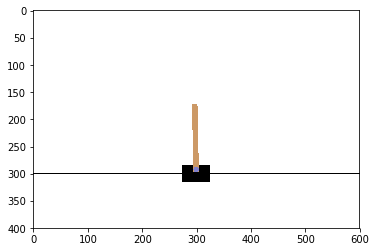

In [65]:
env = gym.make("CartPole-v0").env
env.reset()

plt.imshow(env.render("rgb_array"))
env.close()

Environment is like game: you push some button (perform action) and get back new frame (new state or new observation) and score (reward):

* **observation** (object): an environment-specific object representing your observation of the environment. For example, pixel data from a camera, joint angles and joint velocities of a robot, or the board state in a board game.
* **reward** (float): amount of reward achieved by the previous action. The scale varies between environments, but the goal is always to increase your total reward.
* **done** (boolean): whether it’s time to reset the environment again. Most (but not all) tasks are divided up into well-defined episodes, and done being True indicates the episode has terminated. (For example, perhaps the pole tipped too far, or you lost your last life.)
* **info** (dict): diagnostic information useful for debugging. It can sometimes be useful for learning (for example, it might contain the raw probabilities behind the environment’s last state change). However, official evaluations of your agent are not allowed to use this for learning.

In [66]:
next_s, r, done, info = env.step(env.action_space.sample())

print("next_s = ", next_s)
print("r = ", r)
print("done = ", done)
print("info = ", info)

next_s =  [-0.00618072 -0.17929972 -0.02283427  0.30813903]
r =  1.0
done =  False
info =  {}


Also we can get information about environment dimensions:

In [67]:
n_actions = env.action_space.n
state_dim = env.observation_space.shape

print("n_actions = ", n_actions)
print("state_dim = ", state_dim)

n_actions =  2
state_dim =  (4,)


2 actions:
1. `left`
2. `right`
 
4 numbers in state:
1. `position`
2. `velocity`
3. `angle`
4. `velocity at tip`

# Approximate Q-learning: building the network

To train a neural network policy one must have a neural network policy. Let's build it.


Since we're working with a pre-extracted features (cart positions, angles and velocities), we don't need a complicated network yet. In fact, let's build something like this for starters:

![img](https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring19/yet_another_week/_resource/qlearning_scheme.png)

For your first run, please only use linear layers (nn.Linear) and activations. Stuff like batch normalization or dropout may ruin everything if used haphazardly. 

Also please avoid using nonlinearities like sigmoid & tanh: agent's observations are not normalized so sigmoids may become saturated from init.

Ideally you should start small with maybe 1-2 hidden layers with < 200 neurons and then increase network size if agent doesn't beat the target score.

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [69]:
network = nn.Sequential(
    ## your code here
)

In [70]:
def get_action(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    
    state = torch.tensor(state[None], dtype=torch.float32)
    q_values = network(state).detach().numpy()

    # epsilon greedy strategy
    ## your code here

    return action

In [71]:
s = env.reset()

assert tuple(network(torch.tensor([s]*3, dtype=torch.float32)).size()) == (
    3, n_actions), "please make sure your model maps state s -> [Q(s,a0), ..., Q(s, a_last)]"
assert isinstance(list(network.modules(
))[-1], nn.Linear), "please make sure you predict q-values without nonlinearity (ignore if you know what you're doing)"
assert isinstance(get_action(
    s), int), "get_action(s) must return int, not %s. try int(action)" % (type(get_action(s)))

# test epsilon-greedy exploration
for eps in [0., 0.1, 0.5, 1.0]:
    state_frequencies = np.bincount(
        [get_action(s, epsilon=eps) for i in range(10000)], minlength=n_actions)
    best_action = state_frequencies.argmax()
    assert abs(state_frequencies[best_action] -
               10000 * (1 - eps + eps / n_actions)) < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] -
                       10000 * (eps / n_actions)) < 200
    print('e=%.1f tests passed' % eps)

e=0.0 tests passed
e=0.1 tests passed
e=0.5 tests passed
e=1.0 tests passed


### Q-learning via gradient descent

We shall now train our agent's Q-function by minimizing the TD loss:
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$


Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

The tricky part is with  $Q_{-}(s',a')$. From an engineering standpoint, it's the same as $Q_{\theta}$ - the output of your neural network policy. However, when doing gradient descent, __we won't propagate gradients through it__ to make training more stable (see lectures).

To do so, we shall use `x.detach()` function which basically says "consider this thing constant when doingbackprop".

In [72]:
def to_one_hot(y_tensor, n_dims=None):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    return y_one_hot

def where(cond, x_1, x_2):
    """ helper: like np.where but in pytorch. """
    return (cond * x_1) + ((1-cond) * x_2)

In [73]:
def compute_td_loss(states, actions, rewards, next_states, is_done, gamma=0.99, check_shapes=False):
    """ Compute td loss using torch operations only. Use the formula above. """
    states = torch.tensor(states, dtype=torch.float32)    # shape: [batch_size, state_size]
    actions = torch.tensor(actions, dtype=torch.int32)    # shape: [batch_size]
    rewards = torch.tensor(rewards, dtype=torch.float32)  # shape: [batch_size]
    next_states = torch.tensor(next_states, dtype=torch.float32)  # shape: [batch_size, state_size]
    is_done = torch.tensor(is_done, dtype=torch.float32)  # shape: [batch_size]

    # get q-values for all actions in current states
    predicted_qvalues = ## your code here

    # select q-values for chosen actions
    predicted_qvalues_for_actions = torch.sum(predicted_qvalues * to_one_hot(actions, n_actions), dim=1)  # shape: [batch_size]

    # compute q-values for all actions in next states
    predicted_next_qvalues = ## your code here

    # compute V*(next_states) using predicted next q-values
    next_state_values =  ## your code here
    assert next_state_values.dtype == torch.float32

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    target_qvalues_for_actions = ## your code here

    # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    target_qvalues_for_actions = where(is_done, rewards, target_qvalues_for_actions)

    # mean squared error loss to minimize (don't forget to .detach())
    loss = ## your code here

    return loss

In [74]:
# sanity checks
s = env.reset()
a = env.action_space.sample()
next_s, r, done, _ = env.step(a)
loss = compute_td_loss([s], [a], [r], [next_s], [done], check_shapes=True)
loss.backward()

assert len(loss.size()) == 0, "you must return scalar loss - mean over batch"
assert np.any(next(network.parameters()).grad.detach().numpy() != 0), "loss must be differentiable w.r.t. network weights"

### Playing the game

In [75]:
opt = torch.optim.Adam(network.parameters(), lr=1e-4)
epsilon = 0.5

In [76]:
def generate_session(t_max=1000, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    s = env.reset()

    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)
        next_s, r, done, _ = ## your code here

        if train:
            opt.zero_grad()
            compute_td_loss([s], [a], [r], [next_s], [done]).backward()
            opt.step()

        total_reward += r
        s = next_s
        if done:
            break

    return total_reward

In [77]:
for i in range(1000):
    session_rewards = [generate_session(epsilon=epsilon, train=True) for _ in range(100)]
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))

    epsilon *= 0.99
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"

    if np.mean(session_rewards) > 300:
        print("You Win!")
        break

epoch #0	mean reward = 13.920	epsilon = 0.500
epoch #1	mean reward = 14.450	epsilon = 0.495
epoch #2	mean reward = 13.950	epsilon = 0.490
epoch #3	mean reward = 13.580	epsilon = 0.485
epoch #4	mean reward = 12.840	epsilon = 0.480
epoch #5	mean reward = 13.720	epsilon = 0.475
epoch #6	mean reward = 13.780	epsilon = 0.471
epoch #7	mean reward = 14.620	epsilon = 0.466
epoch #8	mean reward = 20.190	epsilon = 0.461
epoch #9	mean reward = 13.060	epsilon = 0.457
epoch #10	mean reward = 13.110	epsilon = 0.452
epoch #11	mean reward = 12.710	epsilon = 0.448
epoch #12	mean reward = 14.790	epsilon = 0.443
epoch #13	mean reward = 13.620	epsilon = 0.439
epoch #14	mean reward = 13.130	epsilon = 0.434
epoch #15	mean reward = 12.790	epsilon = 0.430
epoch #16	mean reward = 15.290	epsilon = 0.426
epoch #17	mean reward = 12.330	epsilon = 0.421
epoch #18	mean reward = 12.350	epsilon = 0.417
epoch #19	mean reward = 14.360	epsilon = 0.413
epoch #20	mean reward = 12.420	epsilon = 0.409
epoch #21	mean reward =

KeyboardInterrupt: 

### How to interpret results


Welcome to the f world of deep f reinforcement learning. Don't expect agent's reward to smoothly go up. Hope for it to go increase eventually. If it deems you worthy.

Seriously though,
* **mean reward** is the average reward per game. For a correct implementation it may stay low for some 10 epochs, then start growing while oscilating insanely and converges by ~50-100 steps depending on the network architecture. 
* If it never reaches target score by the end of for loop, try increasing the number of hidden neurons or look at the epsilon.
* **epsilon** - agent's willingness to explore. If you see that agent's already at < 0.01 epsilon before it's is at least 200, just reset it back to 0.1 - 0.5.

### Record videos

As usual, we now use `gym.wrappers.Monitor` to record a video of our agent playing the game. Unlike our previous attempts with state binarization, this time we expect our agent to act ~~(or fail)~~ more smoothly since there's no more binarization error at play.

As you already did with tabular q-learning, we set epsilon=0 for final evaluation to prevent agent from exploring himself to death.

In [78]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True)
sessions = [generate_session(epsilon=0, train=False) for _ in range(100)]
env.close()

In [79]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices